In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import os

# Define our own plot function
def scatter(x, labels, root='plot', subtitle=None, dataset='MNIST'):
    
    num_classes = len(set(labels)) # Calculate the number of classes
    palette = np.array(sns.color_palette("hls", num_classes)) # Choosing color

    ## Create a seaborn scatter plot ##
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ## ---------------------------- ##
    
    ## Add label on top of each cluster ##
    if dataset=='MNIST':
        idx2name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif dataset=='CIFAR10':
        idx2name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    else:
        raise Exception("Please specify the dataset")
        
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, idx2name[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)        
        
    ## ---------------------------- ##    
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    if not os.path.exists(root):
        os.makedirs(root)        
    plt.savefig(os.path.join(root, str(subtitle)))

In [2]:
device = torch.device('cuda:0')
tsne = TSNE(random_state=0)
batch_size_train = 16 # When the batch size is too huge the model collapse, but why?
vis_batch_size_train = 256

In [3]:
train_loader = DataLoader(MNIST('./MNIST/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=vis_batch_size_train, shuffle=True)
test_loader = DataLoader(MNIST('./MNIST/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=vis_batch_size_train, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [4]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

In [5]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

In [6]:
train_loader = DataLoader(MNIST('./MNIST/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(MNIST('./MNIST/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use

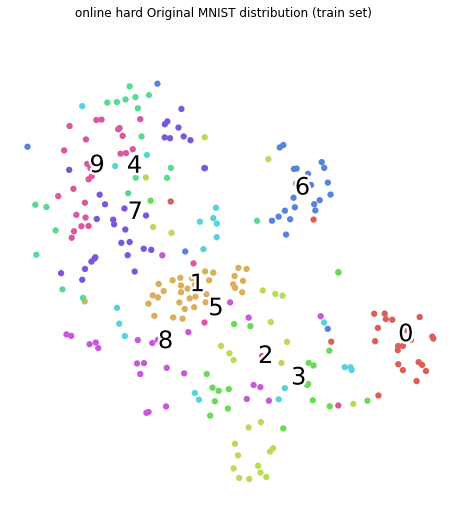

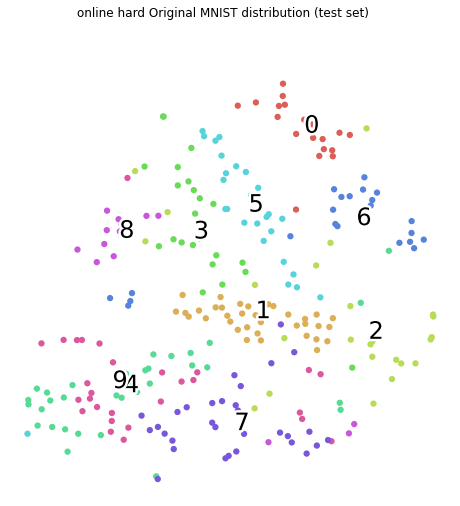

In [9]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online hard Original MNIST distribution (train set)')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online hard Original MNIST distribution (test set)')


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TNN(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(TNN, self).__init__()
        self.cnn1 = nn.Conv2d(input_shape[0], 128, (7,7))
        self.cnn2 = nn.Conv2d(128, 256, (5,5))
        self.pooling = nn.MaxPool2d((2,2), (2,2))
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
             
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = F.relu(self.cnn1(x))
        x = self.pooling(x)
        x = F.relu(self.cnn2(x))
        x = self.pooling(x)
        return x     
        
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x

    
def AddGaussianNoise(tensor, mean=0., std=1.):      
    return tensor + torch.randn(tensor.size(), device=tensor.device) * std + mean    
    
class SimpleTNN(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(SimpleTNN, self).__init__()
        self.CNN_outshape = self._get_output(input_shape)
        self.linear1 = nn.Linear(self.CNN_outshape, 512)
        self.linear2 = nn.Linear(512, output_size)
        self.drop = nn.Dropout(p=0.1)
             
    def _get_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        output_shape = dummy_x.flatten(1).size(1)
        return output_shape
     
        
    def forward(self, x):
        x = torch.relu(self.linear1(x.flatten(1)))
        x = self.drop(x)
        x = self.linear2(AddGaussianNoise(x, mean=0, std=1e-2))
        x = self.drop(x)
        return x 
    
class TNN_CIFAR10(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(TNN_CIFAR10, self).__init__()
        self.cnn1a = nn.Conv2d(input_shape[0], 16, kernel_size=3)
        self.cnn1b = nn.Conv2d(16, 16, kernel_size=3)
        self.cnn2a = nn.Conv2d(16, 32, kernel_size=3)
        self.cnn2b = nn.Conv2d(32, 32, kernel_size=3)
        self.cnn3a = nn.Conv2d(32, 64, kernel_size=3)
        self.cnn3b = nn.Conv2d(64, 64, kernel_size=3)
        self.pooling = nn.MaxPool2d((3,3), (1,1))
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size, bias=False)
             
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = F.relu(self.cnn1a(x))
        x = self.pooling(x)
        x = F.relu(self.cnn1b(x))
        x = self.pooling(x)        
        
        x = F.relu(self.cnn2a(x))
        x = self.pooling(x)
        x = F.relu(self.cnn2b(x))
        x = self.pooling(x)
        
        x = F.relu(self.cnn3a(x))
        x = self.pooling(x)        
        x = F.relu(self.cnn3b(x))
        x = self.pooling(x)    
        return x     
        
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
    
class TNN_CIFAR10_Drop(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(TNN_CIFAR10_Drop, self).__init__()
        self.cnn1a = nn.Conv2d(input_shape[0], 16, kernel_size=5)
        self.cnn2a = nn.Conv2d(16, 32, kernel_size=5)
        self.cnn3a = nn.Conv2d(32, 64, kernel_size=5)
        self.pooling = nn.MaxPool2d((3,3), (1,1))
        self.drop2d = nn.Dropout(p=0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
             
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = F.relu(self.drop2d(self.cnn1a(x)))
        x = self.pooling(x)        
        
        x = F.relu(self.drop2d(self.cnn2a(x)))
        x = self.pooling(x)
        
        x = F.relu(self.drop2d(self.cnn3a(x)))
        x = self.pooling(x)        
  
        return x     
        
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x    
    
    
class TNN_CIFAR10_Dropv2(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(TNN_CIFAR10_Dropv2, self).__init__()
        self.cnn1a = nn.Conv2d(input_shape[0], 16, kernel_size=5)
        self.cnn1b = nn.Conv2d(16, 16, kernel_size=3)
        self.cnn2a = nn.Conv2d(16, 32, kernel_size=5)
        self.cnn2b = nn.Conv2d(32, 32, kernel_size=3)
        self.cnn3a = nn.Conv2d(32, 64, kernel_size=5)
        self.cnn3b = nn.Conv2d(64, 64, kernel_size=3)
        self.pooling = nn.MaxPool2d((3,3), (1,1))
        self.drop = nn.Dropout(p=0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, 512)
        self.linear_out = nn.Linear(512, output_size)    
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = F.relu(self.cnn1a(x))
        x = F.relu(self.cnn1b(x))
        x = self.pooling(x)        
        
        x = F.relu(self.cnn2a(x))
        x = F.relu(self.cnn2b(x))
        x = self.pooling(x)
        
        x = F.relu(self.cnn3a(x))
        x = F.relu(self.cnn3b(x))
        x = self.pooling(x)        
  
        return x     
        
    def forward(self, x):
        x = self._forward_features(x)
        x = self.drop(self.linear(x.flatten(1)))
        return x    
    
    
class TNN_CIFAR10_Drop2d(nn.Module):
    def __init__(self, input_shape=(), output_size=4):
        super(TNN_CIFAR10_Drop2d, self).__init__()
        self.cnn1a = nn.Conv2d(input_shape[0], 16, kernel_size=5)
        self.cnn2a = nn.Conv2d(16, 32, kernel_size=5)
        self.cnn3a = nn.Conv2d(32, 64, kernel_size=5)
        self.pooling = nn.MaxPool2d((3,3), (1,1))
        self.drop2da = nn.Dropout2d(p=0.15)
        self.drop2db = nn.Dropout2d(p=0.1)
        self.drop1d = nn.Dropout(p=0.1)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
             
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = F.relu(self.drop2da(self.cnn1a(x)))
        x = self.pooling(x)        
        
        x = F.relu(self.drop2db(self.cnn2a(x)))
        x = self.pooling(x)
        
        x = F.relu(self.drop2db(self.cnn3a(x)))
        x = self.pooling(x)        
  
        return x     
        
    def forward(self, x):
        x = self._forward_features(x)
        x = F.tanh(self.linear(x.flatten(1)))
        return x        
    
    
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
    
    
class VGG(nn.Module):
    def __init__(self, input_shape, vgg_name, output_size):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.classifier = nn.Linear(self.CNN_outshape, output_size)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    
    def _forward_features(self, x):
        x = self.features(x)        
        return x      

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
#                            nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [12]:
model = TNN(input_shape=x_train.shape[1:])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
import os
import random
from itertools import permutations
import numpy as np
import torch

"""
This code is a re-implmentationm of the code written in Tensorflow
https://omoindrot.github.io/triplet-loss
https://github.com/omoindrot/tensorflow-triplet-loss
All the doc strings and comments are from the original implmentation
"""


def offline(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)


def _get_triplet_mask(labels, device='cpu'):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: torch.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = torch.eye(labels.size()[0]).type(torch.ByteTensor) # make a index in Bool
    indices_not_equal = -(indices_equal-1) # flip booleans
    i_not_equal_j = torch.unsqueeze(indices_not_equal, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_equal, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_equal, 0)

    distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = (torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)

    valid_labels = (i_equal_j & ~i_equal_k)
    # Combine the two masks
    
    mask = (distinct_indices.to(device).bool() & valid_labels)

    return mask


def _pairwise_distances(embeddings, squared=False, device='cpu'):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    embeddings = torch.squeeze(embeddings,1)  # shape=(batch_size, features, 1)
    dot_product = torch.matmul(embeddings, torch.transpose(embeddings,0,1)) # shape=(batch_size, batch_size)
    
    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = torch.unsqueeze(square_norm, 1) - 2.0 * dot_product + torch.unsqueeze(square_norm, 0)
    
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.Tensor([0.0]).to(device))
    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = (distances == 0.0).float()
        distances = distances + mask * 1e-16
        distances = torch.sqrt(distances)
        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)
    # return distances matrix (batch X batch)
    return distances


def online_mine_all(labels, embeddings, margin, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared, device=device)
    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = torch.unsqueeze(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = torch.unsqueeze(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels, device=device)
    mask = mask.float()
    
    triplet_loss = mask*triplet_loss

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = torch.max(triplet_loss, torch.Tensor([0.0]).to(device))

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = (triplet_loss > 1e-16).float()
    
    num_positive_triplets = torch.sum(valid_triplets)
    
    num_valid_triplets = torch.sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, num_positive_triplets, num_valid_triplets

def _get_anchor_positive_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = torch.eye(labels.size()[0]).bool().to(device)
    
    indices_not_equal = ~indices_equal # flip booleans

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = (torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1))
    # Combine the two masks
    mask = indices_not_equal & labels_equal

    return mask

def _get_anchor_negative_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.unsqueeze(labels,0) == torch.unsqueeze(labels,1)

    mask = ~labels_equal # invert the boolean tensor

    return mask



def online_mine_hard(labels, embeddings, margin, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared, device=device)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels, device)
    mask_anchor_positive = mask_anchor_positive

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = mask_anchor_positive*pairwise_dist

    # shape (batch_size, 1)
    hardest_positive_dist = torch.max(anchor_positive_dist, 1, keepdim=True)[0]

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels, device)
    mask_anchor_negative = mask_anchor_negative

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = torch.max(pairwise_dist, 1, keepdim=True)[0]
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * ~(mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = torch.min(anchor_negative_dist, 1, keepdim=True)[0]

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = torch.max(hardest_positive_dist - hardest_negative_dist + margin, torch.Tensor([0.0]).to(device))
    
    # Get final mean triplet loss
    triplet_loss = torch.mean(triplet_loss)

    return triplet_loss, torch.sum(mask_anchor_positive), torch.sum(mask_anchor_negative)

In [14]:
margin=0.4
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss, pos_mask, neg_mask = online_mine_hard(labels, outputs,
                                                    margin=margin, squared=True,
                                                    device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print(f"At epoches = {epoch}, i = {i}, loss = {loss:.5f}, pos_mask = {pos_mask}, neg_mask = {neg_mask}"
                  , end='\r')
    epoch_loss = running_loss / len(train_loader)
    
    print(" "*100)
    print(f"At epoches = {epoch}, epoch_loss = {epoch_loss}")
print('Finished Training')

                                                                                                    
At epoches = 0, epoch_loss = 0.13202607991695403
                                                                                                    
At epoches = 1, epoch_loss = 0.05979759499082963
                                                                                                    
At epoches = 2, epoch_loss = 0.042649092454711594
                                                                                                    
At epoches = 3, epoch_loss = 0.03370971393932899
                                                                                                    
At epoches = 4, epoch_loss = 0.027426083020865917
                                                                                                    
At epoches = 5, epoch_loss = 0.022993210983276367
                                                                                                 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use

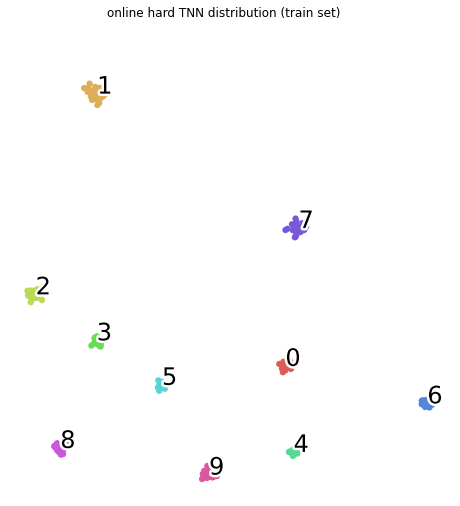

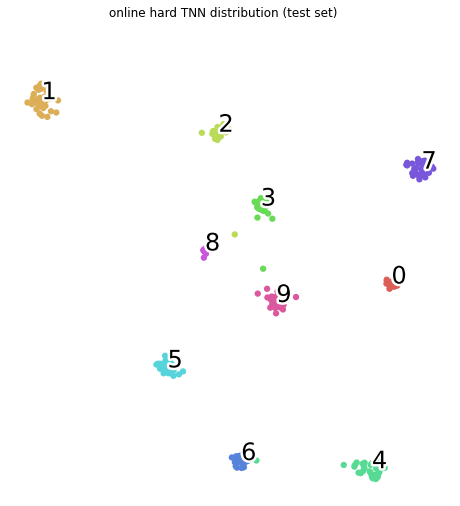

In [15]:
train_outputs = model(x_train)
test_outputs = model(x_test)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online hard TNN distribution (train set)')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online hard TNN distribution (test set)')